In [ ]:
!apt-get update
!apt-get install -y ffmpeg

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,192 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,525 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from google.colab import drive

데이터 경로 설정


In [ ]:
drive.mount('/content/drive')
DATA_PATH = '/content/drive/My Drive/DataSet/genres_original'  # GTZAN 데이터셋 경로
CLASS_LABELS = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


스펙트로그램 생성 함수, 데이터 로드함수 정의

In [ ]:
# 스펙트로그램 생성 함수
def extract_spectrogram(file_path, n_mels=128, max_len=128):
    y, sr = librosa.load(file_path, duration=30)  # 30초로 제한
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    # 패딩 처리 (128x128 고정 크기)
    if spectrogram_db.shape[1] < max_len:
        pad_width = max_len - spectrogram_db.shape[1]
        spectrogram_db = np.pad(spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        spectrogram_db = spectrogram_db[:, :max_len]
    return spectrogram_db

# 데이터 로드 함수
def load_data(data_path, labels):
    spectrograms = []
    genre_labels = []
    for label in labels:
        genre_folder = os.path.join(data_path, label)
        for file in os.listdir(genre_folder):
            if file.endswith('.wav'):  # .wav 파일만 처리
                file_path = os.path.join(genre_folder, file)
                try:
                    spectrogram = extract_spectrogram(file_path)
                    spectrograms.append(spectrogram)
                    genre_labels.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(spectrograms), np.array(genre_labels)


In [ ]:
# 데이터 로드
print("Extracting features from audio files...")
X, y = load_data(DATA_PATH, CLASS_LABELS)

# 데이터 전처리
X = X[..., np.newaxis]  # CNN 입력을 위한 채널 차원 추가 (128, 128, 1)
X = np.repeat(X, 3, axis=-1)  # VGG16은 3채널 이미지를 필요로 하므로 채널 복제 (128, 128, 3)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded, num_classes=len(CLASS_LABELS))

# 학습/검증 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# 사전 학습된 VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False  # 사전 학습된 가중치를 고정

# 분류 계층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)  # GAP 계층 추가
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(CLASS_LABELS), activation='softmax')(x)

# 새 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Extracting features from audio files...


Train

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 207s 8s/step - accuracy: 0.0915 - loss: 5.7976 - val_accuracy: 0.2850 - val_loss: 2.0284
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 212s 9s/step - accuracy: 0.2770 - loss: 2.1757 - val_accuracy: 0.3800 - val_loss: 1.7678
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 298s 10s/step - accuracy: 0.3823 - loss: 1.7208 - val_accuracy: 0.4250 - val_loss: 1.6391
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 210s 9s/step - accuracy: 0.4206 - loss: 1.6008 - val_accuracy: 0.4350 - val_loss: 1.6170
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 259s 8s/step - accuracy: 0.4958 - loss: 1.4721 - val_accuracy: 0.5150 - val_loss: 1.5249
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 262s 8s/step - accuracy: 0.5119 - loss: 1.3806 - val_accuracy: 0.5350 - val_loss: 1.4935
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step - accuracy: 0.5363 - loss: 1.2664 - val_accuracy: 0.5300 - val_loss: 1.4525
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 262s 8s/step - accuracy: 0.5435 - loss: 1.2549 - val_accuracy: 0.5400 - 

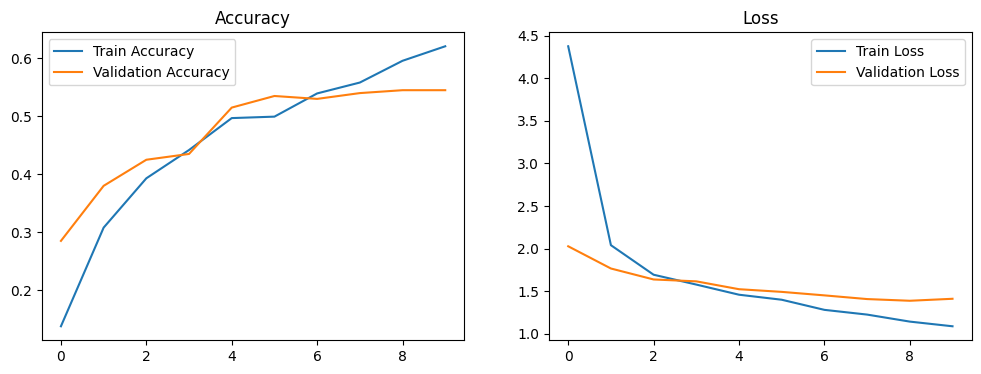

In [ ]:
# 모델 학습
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 학습 과정 시각화
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history)